## Estimate Posterior using MCMC
study group tutorial 16jan19 / jplewis

source is in D/Julia/Learning, not Notes/Notebooks

In [49]:
using PyPlot
p_ = PyPlot

PyPlot

### test out Distributions package

In [50]:
using Distributions
noisesigma = 0.1
noise = Distributions.Normal(0., noisesigma)
gaussian(val,μ,σ) = (1. /sqrt(2. * π * σ^2 )) * exp( - (val-μ)^2 / (2. * σ^2))
(gaussian(2.3,0,noisesigma), Distributions.pdf(noise,2.3))
(gaussian(-0.3,0,noisesigma), Distributions.pdf(noise,-0.3))   # same

(0.044318484119380115, 0.044318484119380115)

### model

A,B ~ N(0,1)

$y = A x + B + \epsilon$

### true parameter values

In [51]:
N = 5  # data points
A = randn()
B = randn()
(A,B)

(0.2587895243533585, -0.6631805958881593)

### Generate sample data

In [52]:
ϵ = noisesigma * randn(N,)   # todo use Distributions package sample
x = 2. * randn(N,)
y = A * x .+ B .+ ϵ

5-element Array{Float64,1}:
 -0.4844628729209091
 -0.8686139237618655
 -0.8090351458705395
 -1.57054144938643  
 -0.6939946719574153

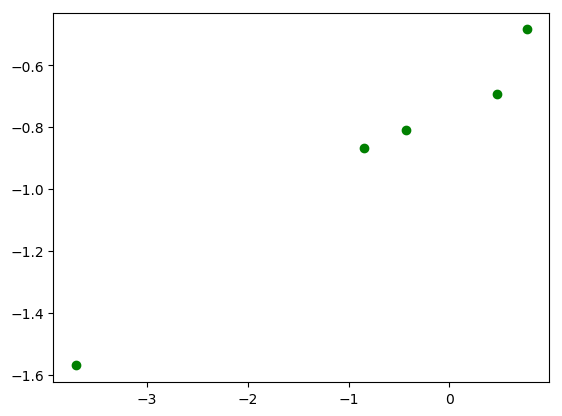

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13cf5f198>

In [53]:
p_.plot(x,y,"go")

### Note likelihood (and improper prior) cancel
General Bayes thm:

$$
    p(M|D) = \frac{ p(D|M) p(M)   }{ p(D)  } = \frac{ p(D|M) p(M)   }{ \int p(D|M) p(M) \, dM   }
$$

For the case of regression:

\begin{align*}
P(\theta|y,x) &= \frac{P(\theta,y,x)}{ P(y,x) }
\\
    &= \frac{ P(y|x,\theta) P(x|\theta) P(\theta) }{ P(y|x) P(x)  }
\\
    P(x|\theta) = P(x) \quad\text{and cancel}  &
\\
    &=  \frac{ P(y|x,\theta) P(\theta) }{ P(y|x) }
\\
\end{align*}

Posterior odds

\begin{align*}
   \frac{ P(\theta_1|y,x) }{ P(\theta|y,x) } &=   \frac{ \frac{ P(y|x,\theta_1) P(\theta_1) }{ P(y|x) } }{ \frac{ P(y|x,\theta) P(\theta) }{ P(y|x) } }     \quad=\quad  \frac{ P(y|x,\theta_1) P(\theta_1) }{  P(y|x,\theta) P(\theta)  }
\end{align*}

For the case of Gaussian noise $\epsilon$

$$
P(y|x,\theta) = \prod \frac{1}{\sqrt{ 2 \pi \sigma^2}} \exp(- \frac{1}{2}|y_i - (a x_i + b)|^2 / \sigma^2) 
$$

log likelihood = 

$$ 
-\frac{N}{2}\log(2 \pi \sigma^2) \quad-\quad  \left( \sum |y_i - (a x_i + b)|^2 / (2\sigma^2) \right) 
$$

(details)

\begin{align*}
&   \log \frac{1}{\sqrt{2 \pi \sigma^2}}
\\
&= \log 1  - \log ( 2 \pi \sigma^2 )^{1/2}
 \\
&=   0  - \frac{1}{2} \log{ 2 \pi \sigma^2}
\end{align*}

In [54]:
function loglikelihood(a,b)
    noisesigma2 = noisesigma*noisesigma
    ll = 0.
    for ipt = 1:N
        #print("  datapoint $ipt ")
        err = y[ipt] - (a*x[ipt]+b)
        peval = err*err / (2*noisesigma2)
        #print(" p0eval=",peval)
        ll -= peval
    end 
    ll -= (N/2.)*log(2*π*noisesigma2)
    ll
end

loglikelihood (generic function with 1 method)

In [55]:
normal = Distributions.Normal(0., 1.0 )
function logposterior(a,b)
    useprior = false   # else improper/flat prior
    prior = 0.
    if useprior
        prior += log(Distributions.pdf(normal,a))
        prior += log(Distributions.pdf(normal,b))
    end
    prior + loglikelihood(a,b)
end

logposterior (generic function with 1 method)

Stopping test, log version

$$
\frac{ \exp(n)}{\exp(d)} > 1  \quad\rightarrow\quad   n - d > 0 
$$

In [56]:
function mcmc1logposterior(a,b)
    println("mcmc1logposterior initial $a $b")
    
    logposterior0 = logposterior(a,b)
    
    for mciter = 1:100
        #if ((mciter%10)==0) println("  mciter $mciter")  end
        a_ = a + 0.5 * randn()
        b_ = b + 0.5 * randn()       # new proposal
        
        logposterior1 = logposterior(a_,b_)
        
        #println("logp1 $logposterior1,   logp0 $logposterior0")

        p = exp(logposterior1) / exp(logposterior0)
        if (rand() < p)
            println("\nsuccess $a_, $b_")
            return (a_,b_)
        else
            print(".")
        end   
    end
    println("")
    return (a,b)
end

mcmc1logposterior (generic function with 1 method)

In [57]:
function warmup(a,b) 
    for iter = 1:1000 
        if ((iter%10)==0) println("iter $iter")  end
        a,b = mcmc1logposterior(a,b)   
    end
    return (a,b)
end                # warmup


warmup (generic function with 1 method)

In [58]:
function mcmcline(a,b)
    aavg, bavg = (0.,0.)
    Niter = 100000
    for iter = 1:Niter 
        if ((iter%10)==0) println("iter $iter")  end
        a,b = mcmc1logposterior(a,b)   
        aavg += a
        bavg += b
    end
    aavg /= float(Niter)
    bavg /= float(Niter)
    return (aavg,bavg)
end

mcmcline (generic function with 1 method)

In [59]:
# initial posterior estimate
a_, b_ = 0.,0.

a_, b_ = warmup(a_,b_)
aest, best = mcmcline(a_,b_)

print("estimate $aest, $best,   true $A, $B")

mcmc1logposterior initial 0.0 0.0
..
success 0.43799473166436725, -0.5015617595008117
mcmc1logposterior initial 0.43799473166436725 -0.5015617595008117
....
success 0.08640458463686057, -0.9074531745007072
mcmc1logposterior initial 0.08640458463686057 -0.9074531745007072
............................
success 0.17087318051183528, -1.0194649837674297
mcmc1logposterior initial 0.17087318051183528 -1.0194649837674297
...............
success 0.18371153286913697, -0.5530738796174617
mcmc1logposterior initial 0.18371153286913697 -0.5530738796174617

success 0.11618849829537571, -0.7005839153188349
mcmc1logposterior initial 0.11618849829537571 -0.7005839153188349
...................
success 0.17895369398895428, -0.7231388861343461
mcmc1logposterior initial 0.17895369398895428 -0.7231388861343461
..................................
success 0.2175057289132502, -0.6481687626470327
mcmc1logposterior initial 0.2175057289132502 -0.6481687626470327
......................................................

....................................................................................................
mcmc1logposterior initial 0.23208135942533512 -0.691803002918086
.........
success 0.18071957966268487, -0.6800628134517844
iter 70
mcmc1logposterior initial 0.18071957966268487 -0.6800628134517844
....................................................................................................
mcmc1logposterior initial 0.18071957966268487 -0.6800628134517844
................
success 0.20215391433355218, -0.6494711681493908
mcmc1logposterior initial 0.20215391433355218 -0.6494711681493908
....................................................................................................
mcmc1logposterior initial 0.20215391433355218 -0.6494711681493908
....................................................................................................
mcmc1logposterior initial 0.20215391433355218 -0.6494711681493908
....................................................................

mcmc1logposterior initial 0.2420391802912282 -0.7107897887864918
....................................................................................................
mcmc1logposterior initial 0.2420391802912282 -0.7107897887864918
....................................................................................................
mcmc1logposterior initial 0.2420391802912282 -0.7107897887864918
............................................................
success 0.2956085817638754, -0.6127958894013656
mcmc1logposterior initial 0.2956085817638754 -0.6127958894013656
..........................................................
success 0.2530403631090677, -0.7928281983038884
mcmc1logposterior initial 0.2530403631090677 -0.7928281983038884
................
success 0.24475990866500727, -0.7969888447836209
mcmc1logposterior initial 0.24475990866500727 -0.7969888447836209
....................................................................................................
mcmc1logposterior initia

....................................................................................................
iter 230
mcmc1logposterior initial 0.2074141063898125 -0.7540426201440531
......
success 0.27291645698469025, -0.6388201817936173
mcmc1logposterior initial 0.27291645698469025 -0.6388201817936173
.......................
success 0.25197835465056334, -0.7613095233907868
mcmc1logposterior initial 0.25197835465056334 -0.7613095233907868
.......................................................................
success 0.19005506262932623, -0.6958571794262455
mcmc1logposterior initial 0.19005506262932623 -0.6958571794262455
..
success 0.25640880047709463, -0.7024378433280739
mcmc1logposterior initial 0.25640880047709463 -0.7024378433280739
..........................
success 0.2256975269457444, -0.6180219002701249
mcmc1logposterior initial 0.2256975269457444 -0.6180219002701249
...................................
success 0.19050385671431413, -0.752465259274855
mcmc1logposterior initial 0.1905038

....................................................................................................
mcmc1logposterior initial 0.24089384957668583 -0.6495335807074003
.....................................................
success 0.19082860923042017, -0.7419121153111885
mcmc1logposterior initial 0.19082860923042017 -0.7419121153111885
...........................................
success 0.218747801270693, -0.787079454386818
mcmc1logposterior initial 0.218747801270693 -0.787079454386818
....................................................................................................
mcmc1logposterior initial 0.218747801270693 -0.787079454386818
.
success 0.2276192647522785, -0.7611235080221597
mcmc1logposterior initial 0.2276192647522785 -0.7611235080221597
.............................................................
success 0.2070371453291985, -0.7526626755733665
iter 300
mcmc1logposterior initial 0.2070371453291985 -0.7526626755733665
................................................

...........................................................................
success 0.2070755889843654, -0.7071024192202445
mcmc1logposterior initial 0.2070755889843654 -0.7071024192202445
....................................................................................................
mcmc1logposterior initial 0.2070755889843654 -0.7071024192202445
....................................................................................................
mcmc1logposterior initial 0.2070755889843654 -0.7071024192202445
....................................................................................................
mcmc1logposterior initial 0.2070755889843654 -0.7071024192202445
..............
success 0.2236736155235244, -0.7121699145464442
mcmc1logposterior initial 0.2236736155235244 -0.7121699145464442
....................................................................................................
mcmc1logposterior initial 0.2236736155235244 -0.7121699145464442
...................

success 0.23754170258673096, -0.6800922264779614
mcmc1logposterior initial 0.23754170258673096 -0.6800922264779614
.....................................................
success 0.1992906665133173, -0.74632074491467
mcmc1logposterior initial 0.1992906665133173 -0.74632074491467
..............................................................
success 0.31099401174224994, -0.752789722219409
mcmc1logposterior initial 0.31099401174224994 -0.752789722219409
....................
success 0.2321509793182822, -0.8692080749367106
mcmc1logposterior initial 0.2321509793182822 -0.8692080749367106
.............................................
success 0.22660844926015675, -0.6534135399783145
iter 420
mcmc1logposterior initial 0.22660844926015675 -0.6534135399783145
....................................................................................................
mcmc1logposterior initial 0.22660844926015675 -0.6534135399783145
...............................
success 0.24985022034453164, -0.66126072185

mcmc1logposterior initial 0.21557108008708487 -0.6925947842328435
....................................................................................................
mcmc1logposterior initial 0.21557108008708487 -0.6925947842328435
......................................
success 0.22680656406691269, -0.6769980736572332
mcmc1logposterior initial 0.22680656406691269 -0.6769980736572332
....................................................................................................
mcmc1logposterior initial 0.22680656406691269 -0.6769980736572332
................
success 0.2607937593137629, -0.7774960421816498
mcmc1logposterior initial 0.2607937593137629 -0.7774960421816498
....................................................................................................
mcmc1logposterior initial 0.2607937593137629 -0.7774960421816498
..................................................
success 0.1905043056906885, -0.7200645016509989
mcmc1logposterior initial 0.1905043056906885 -0.720

mcmc1logposterior initial 0.24948468823786427 -0.6949142943158441
....................................................................................................
mcmc1logposterior initial 0.24948468823786427 -0.6949142943158441
.......................................................................................
success 0.2267111793043221, -0.7448223274287101
mcmc1logposterior initial 0.2267111793043221 -0.7448223274287101
....................................................................................................
mcmc1logposterior initial 0.2267111793043221 -0.7448223274287101
................................................................
success 0.20618686432365482, -0.7567780908596029
mcmc1logposterior initial 0.20618686432365482 -0.7567780908596029
...............
success 0.24424950987816985, -0.6565432417027439
mcmc1logposterior initial 0.24424950987816985 -0.6565432417027439
....................................................................................
succ

mcmc1logposterior initial 0.2166890393630478 -0.7475592850044538
....................................................................................................
mcmc1logposterior initial 0.2166890393630478 -0.7475592850044538
.................................................................................................
success 0.23053290149130093, -0.7285105683100884
mcmc1logposterior initial 0.23053290149130093 -0.7285105683100884
....................................................................................................
mcmc1logposterior initial 0.23053290149130093 -0.7285105683100884
....................................................................................................
mcmc1logposterior initial 0.23053290149130093 -0.7285105683100884
....................................................................................................
mcmc1logposterior initial 0.23053290149130093 -0.7285105683100884
.......................................................

mcmc1logposterior initial 0.1962700128631714 -0.7831504222385163
..................
success 0.2737953350559894, -0.6486724939219239
mcmc1logposterior initial 0.2737953350559894 -0.6486724939219239
....................................................................................................
iter 740
mcmc1logposterior initial 0.2737953350559894 -0.6486724939219239
....................................................................................................
mcmc1logposterior initial 0.2737953350559894 -0.6486724939219239
....................................................................................................
mcmc1logposterior initial 0.2737953350559894 -0.6486724939219239
...................................................................................
success 0.266366152266886, -0.6842372495461555
mcmc1logposterior initial 0.266366152266886 -0.6842372495461555
...........
success 0.2233450330684824, -0.742230163306119
mcmc1logposterior initial 0.22334503306848

mcmc1logposterior initial 0.2131795955594784 -0.7256102997924933
....................................................................................................
mcmc1logposterior initial 0.2131795955594784 -0.7256102997924933
....................................................................................................
mcmc1logposterior initial 0.2131795955594784 -0.7256102997924933
............................................................
success 0.18193743448003563, -0.7633458474813538
mcmc1logposterior initial 0.18193743448003563 -0.7633458474813538
....................................................................................................
mcmc1logposterior initial 0.18193743448003563 -0.7633458474813538
.........................................................
success 0.203409515343199, -0.7605754924953942
mcmc1logposterior initial 0.203409515343199 -0.7605754924953942
...........................................................................................

....................................................................................................
mcmc1logposterior initial 0.24015902649524712 -0.7050658089032906
..................................
success 0.27277381867046074, -0.7058026265486664
mcmc1logposterior initial 0.27277381867046074 -0.7058026265486664
............
success 0.1878598185754004, -0.669375832157834
iter 860
mcmc1logposterior initial 0.1878598185754004 -0.669375832157834
...................................................................
success 0.19897047367871737, -0.6624291541985986
mcmc1logposterior initial 0.19897047367871737 -0.6624291541985986
....................................................................................................
mcmc1logposterior initial 0.19897047367871737 -0.6624291541985986
..............................
success 0.19888217306170197, -0.71718482577806
mcmc1logposterior initial 0.19888217306170197 -0.71718482577806
..........................................................

mcmc1logposterior initial 0.23945364297369548 -0.7399986142939302
....................................................................................................
mcmc1logposterior initial 0.23945364297369548 -0.7399986142939302
....................................................................................................
mcmc1logposterior initial 0.23945364297369548 -0.7399986142939302

success 0.18885770685222786, -0.7604324457255887
mcmc1logposterior initial 0.18885770685222786 -0.7604324457255887
..................................................
success 0.2425947198882386, -0.6960567084942055
mcmc1logposterior initial 0.2425947198882386 -0.6960567084942055
..........................
success 0.2746594203798918, -0.6795666909598838
mcmc1logposterior initial 0.2746594203798918 -0.6795666909598838
......
success 0.24715568595947382, -0.7108924888643757
mcmc1logposterior initial 0.24715568595947382 -0.7108924888643757
.....
success 0.16751041448992712, -0.764251980968232
mcmc

mcmc1logposterior initial 0.22741017466480057 -0.73849252105536
....................................................................................................
mcmc1logposterior initial 0.22741017466480057 -0.73849252105536
....................................................................................................
mcmc1logposterior initial 0.22741017466480057 -0.73849252105536
..................................................
success 0.21630263148299617, -0.7418841278183226
mcmc1logposterior initial 0.21630263148299617 -0.7418841278183226
.........................................................................................
success 0.1683314626150511, -0.6875419801628673
mcmc1logposterior initial 0.1683314626150511 -0.6875419801628673
..................................................................................
success 0.1766193085417457, -0.6585998254947707
mcmc1logposterior initial 0.1766193085417457 -0.6585998254947707
....................................
succ

....................................................................................................
mcmc1logposterior initial 0.2645521848085482 -0.7199940639527692
....................................................................................................
mcmc1logposterior initial 0.2645521848085482 -0.7199940639527692
.............................................................................................
success 0.2650626276606291, -0.6695139538499353
mcmc1logposterior initial 0.2650626276606291 -0.6695139538499353
....................................................................................................
iter 90
mcmc1logposterior initial 0.2650626276606291 -0.6695139538499353
..............................................
success 0.2381034382689836, -0.7092356109450362
mcmc1logposterior initial 0.2381034382689836 -0.7092356109450362
....................................................................................................
mcmc1logposterior initial 

success 0.18336669573521497, -0.7742554382679357
mcmc1logposterior initial 0.18336669573521497 -0.7742554382679357
....................................................................................................
mcmc1logposterior initial 0.18336669573521497 -0.7742554382679357
....................................................................................................
mcmc1logposterior initial 0.18336669573521497 -0.7742554382679357
..............
success 0.2877037696659988, -0.6363566187829869
mcmc1logposterior initial 0.2877037696659988 -0.6363566187829869
....................................................................................................
mcmc1logposterior initial 0.2877037696659988 -0.6363566187829869
.....................................................
success 0.29062375243167715, -0.6495681487631437
mcmc1logposterior initial 0.29062375243167715 -0.6495681487631437
.....................................
success 0.2504215079564269, -0.6039883162965847
mc

....................................................................................................
mcmc1logposterior initial 0.253199397579654 -0.6729550108252754
....................................................................................................
mcmc1logposterior initial 0.253199397579654 -0.6729550108252754
....................................................................................................
mcmc1logposterior initial 0.253199397579654 -0.6729550108252754
.................................................................
success 0.2299913488934827, -0.7589166369026358
mcmc1logposterior initial 0.2299913488934827 -0.7589166369026358
....................................................................................................
mcmc1logposterior initial 0.2299913488934827 -0.7589166369026358
....................................................................................................
mcmc1logposterior initial 0.2299913488934827 -0.75891663690

mcmc1logposterior initial 0.2237286293765095 -0.7560372596582897
..................................................................................
success 0.19115071465531358, -0.7421991348935155
iter 280
mcmc1logposterior initial 0.19115071465531358 -0.7421991348935155
....................................................................................................
mcmc1logposterior initial 0.19115071465531358 -0.7421991348935155
..........................
success 0.24953926951470554, -0.7900273551618203
mcmc1logposterior initial 0.24953926951470554 -0.7900273551618203
......................................................................................
success 0.23517107435250548, -0.6412272889819726
mcmc1logposterior initial 0.23517107435250548 -0.6412272889819726
....................................................................................................
mcmc1logposterior initial 0.23517107435250548 -0.6412272889819726
..................................................

mcmc1logposterior initial 0.26779638181514076 -0.7068117087048652
..............................
success 0.2128409849678184, -0.6672349980752794
mcmc1logposterior initial 0.2128409849678184 -0.6672349980752794
..............................................
success 0.25055698489914413, -0.7013756387460324
mcmc1logposterior initial 0.25055698489914413 -0.7013756387460324
....................................................................................................
mcmc1logposterior initial 0.25055698489914413 -0.7013756387460324
....................................................................................................
mcmc1logposterior initial 0.25055698489914413 -0.7013756387460324
....................................................................................................
mcmc1logposterior initial 0.25055698489914413 -0.7013756387460324
..........................................................
success 0.18917137866790704, -0.7378307156070553
mcmc1logposterior i

mcmc1logposterior initial 0.25686705176453495 -0.6813968406791169
.......................................................................................
success 0.25959009050680526, -0.7226644062632963
mcmc1logposterior initial 0.25959009050680526 -0.7226644062632963
........................................................................................
success 0.22252486722972592, -0.7011267172125022
mcmc1logposterior initial 0.22252486722972592 -0.7011267172125022
....................................................................................................
mcmc1logposterior initial 0.22252486722972592 -0.7011267172125022
.............................................................................................
success 0.2428348563351804, -0.6954801743495257
iter 410
mcmc1logposterior initial 0.2428348563351804 -0.6954801743495257
......................................................................
success 0.2683786130107446, -0.6653266122866393
mcmc1logposterior initial

.........................................
success 0.24400828850042955, -0.6916638372262238
mcmc1logposterior initial 0.24400828850042955 -0.6916638372262238
....................................................
success 0.3041175676273716, -0.6905220506410519
mcmc1logposterior initial 0.3041175676273716 -0.6905220506410519
...............................................................
success 0.31093419860453386, -0.710548231940106
mcmc1logposterior initial 0.31093419860453386 -0.710548231940106
...................................................................
success 0.2150841932843523, -0.8577779036118535
mcmc1logposterior initial 0.2150841932843523 -0.8577779036118535
.....................................
success 0.22382683182293545, -0.6615467066467206
iter 480
mcmc1logposterior initial 0.22382683182293545 -0.6615467066467206
....................................
success 0.1836107931760499, -0.7076853295737519
mcmc1logposterior initial 0.1836107931760499 -0.7076853295737519
.......

..................................................
success 0.2132846995411994, -0.747747428819155
mcmc1logposterior initial 0.2132846995411994 -0.747747428819155
..............................................................
success 0.24352804100949454, -0.6903462744640175
iter 540
mcmc1logposterior initial 0.24352804100949454 -0.6903462744640175
..............................................
success 0.21090835978535913, -0.7518538758109541
mcmc1logposterior initial 0.21090835978535913 -0.7518538758109541
..................................................................................
success 0.23836825076083812, -0.7448319102780161
mcmc1logposterior initial 0.23836825076083812 -0.7448319102780161
....................................................................................................
mcmc1logposterior initial 0.23836825076083812 -0.7448319102780161
.
success 0.2031149267200727, -0.7191216920688869
mcmc1logposterior initial 0.2031149267200727 -0.7191216920688869
.........

mcmc1logposterior initial 0.26452199628683337 -0.704706172981426
....................
success 0.23883549354894615, -0.7286277165628898
mcmc1logposterior initial 0.23883549354894615 -0.7286277165628898
.................
success 0.22683856270558106, -0.7158398572362675
mcmc1logposterior initial 0.22683856270558106 -0.7158398572362675
....................................................................................................
mcmc1logposterior initial 0.22683856270558106 -0.7158398572362675
....................................................................................................
mcmc1logposterior initial 0.22683856270558106 -0.7158398572362675
....................................................................................................
mcmc1logposterior initial 0.22683856270558106 -0.7158398572362675
....................................................................................
success 0.224335051806301, -0.6205608251316407
mcmc1logposterior initial 0.22433

mcmc1logposterior initial 0.23717102651105754 -0.7228180508306006
....................................................................................................
mcmc1logposterior initial 0.23717102651105754 -0.7228180508306006
..............................................
success 0.23273731605446604, -0.7260447002588691
mcmc1logposterior initial 0.23273731605446604 -0.7260447002588691
....................................................................................................
mcmc1logposterior initial 0.23273731605446604 -0.7260447002588691
....................................
success 0.19681864973725227, -0.7450908139135759
mcmc1logposterior initial 0.19681864973725227 -0.7450908139135759
................................................................................
success 0.24996829598822384, -0.6748677265944575
mcmc1logposterior initial 0.24996829598822384 -0.6748677265944575
..........................................................................................

..................................................................
success 0.25285238801079135, -0.7023000954391756
mcmc1logposterior initial 0.25285238801079135 -0.7023000954391756
....................................................................................................
mcmc1logposterior initial 0.25285238801079135 -0.7023000954391756
.........................
success 0.21513047924827408, -0.7811407640715442
mcmc1logposterior initial 0.21513047924827408 -0.7811407640715442
....................................................................................................
mcmc1logposterior initial 0.21513047924827408 -0.7811407640715442
...........................
success 0.24774667849430487, -0.6612533384036354
mcmc1logposterior initial 0.24774667849430487 -0.6612533384036354
....................................................................................................
mcmc1logposterior initial 0.24774667849430487 -0.6612533384036354
..........
success 0.221376638672

....................................
success 0.19892383060296917, -0.6902572193626089
mcmc1logposterior initial 0.19892383060296917 -0.6902572193626089
.....................................................
success 0.23909645282509223, -0.7033307584228411
mcmc1logposterior initial 0.23909645282509223 -0.7033307584228411
....................................................................................................
iter 810
mcmc1logposterior initial 0.23909645282509223 -0.7033307584228411
.......................................................
success 0.21733744958165696, -0.7336895243432473
mcmc1logposterior initial 0.21733744958165696 -0.7336895243432473
..................................................................................................
success 0.26813626212529945, -0.6907964122456018
mcmc1logposterior initial 0.26813626212529945 -0.6907964122456018
...
success 0.20209560174497657, -0.770877081214788
mcmc1logposterior initial 0.20209560174497657 -0.770877081214788
.

mcmc1logposterior initial 0.15660007404843967 -0.7897004538212721
...............................................
success 0.22962215985499163, -0.79924202139324
mcmc1logposterior initial 0.22962215985499163 -0.79924202139324
..
success 0.22590179624863876, -0.7238883436454405
mcmc1logposterior initial 0.22590179624863876 -0.7238883436454405
....................................................................................................
iter 880
mcmc1logposterior initial 0.22590179624863876 -0.7238883436454405
....................................................................................................
mcmc1logposterior initial 0.22590179624863876 -0.7238883436454405
....................................................................................................
mcmc1logposterior initial 0.22590179624863876 -0.7238883436454405
....................................................................................................
mcmc1logposterior initial 0.22590179624863876 

mcmc1logposterior initial 0.2242595626231987 -0.6861430821802634
....................................................................................................
mcmc1logposterior initial 0.2242595626231987 -0.6861430821802634
....................................................................................................
mcmc1logposterior initial 0.2242595626231987 -0.6861430821802634
.................................
success 0.21366416883707587, -0.7107436212463415
mcmc1logposterior initial 0.21366416883707587 -0.7107436212463415
..................................................................................
success 0.24522762245207552, -0.7352062285924603
mcmc1logposterior initial 0.24522762245207552 -0.7352062285924603
....................................................................................................
mcmc1logposterior initial 0.24522762245207552 -0.7352062285924603
.........................................................................................

mcmc1logposterior initial 0.22340645380929378 -0.7092490119648879
...........................................................................................
success 0.25077183653900775, -0.6139806418141116
mcmc1logposterior initial 0.25077183653900775 -0.6139806418141116
.................................................................
success 0.24944563037682163, -0.6974377193313575
mcmc1logposterior initial 0.24944563037682163 -0.6974377193313575
....................................................................................................
iter 1010
mcmc1logposterior initial 0.24944563037682163 -0.6974377193313575
........
success 0.22056510145855943, -0.7087731566367431
mcmc1logposterior initial 0.22056510145855943 -0.7087731566367431
.....................................................................
success 0.22902103048409003, -0.695309253490885
mcmc1logposterior initial 0.22902103048409003 -0.695309253490885
..............................................................

mcmc1logposterior initial 0.2124233248834396 -0.7199722680074931

success 0.267020723278737, -0.7335486273974288
mcmc1logposterior initial 0.267020723278737 -0.7335486273974288
....................................................................................................
mcmc1logposterior initial 0.267020723278737 -0.7335486273974288
.............
success 0.2763925958828839, -0.6278599693298574
mcmc1logposterior initial 0.2763925958828839 -0.6278599693298574
....................
success 0.14263884917673014, -0.7578561267141332
mcmc1logposterior initial 0.14263884917673014 -0.7578561267141332
...............................
success 0.2919448254151502, -0.6650267624460485
mcmc1logposterior initial 0.2919448254151502 -0.6650267624460485
.
success 0.25428381635904895, -0.6855713503442218
mcmc1logposterior initial 0.25428381635904895 -0.6855713503442218
..............................................................
success 0.1554774821266457, -0.7237169659534217
mcmc1logposterior init

mcmc1logposterior initial 0.251517915343932 -0.6751052009970261
........................................................................................
success 0.23666684939801824, -0.7199207110168875
mcmc1logposterior initial 0.23666684939801824 -0.7199207110168875
....................................................................................................
iter 1150
mcmc1logposterior initial 0.23666684939801824 -0.7199207110168875
....................................................................................................
mcmc1logposterior initial 0.23666684939801824 -0.7199207110168875
...........
success 0.2364534247252168, -0.7585457011885803
mcmc1logposterior initial 0.2364534247252168 -0.7585457011885803
.................................................................
success 0.23959948500272582, -0.7656050531284428
mcmc1logposterior initial 0.23959948500272582 -0.7656050531284428
.
success 0.22097361434246005, -0.7248162548245587
mcmc1logposterior initial 0.220

............................................
success 0.19609800195060847, -0.7383967429269325
mcmc1logposterior initial 0.19609800195060847 -0.7383967429269325
....................................................................................................
mcmc1logposterior initial 0.19609800195060847 -0.7383967429269325
....................................................................................................
mcmc1logposterior initial 0.19609800195060847 -0.7383967429269325
....................................................................
success 0.19895937548390943, -0.6902896133561595
mcmc1logposterior initial 0.19895937548390943 -0.6902896133561595
....................................................................................................
mcmc1logposterior initial 0.19895937548390943 -0.6902896133561595
.......................................................
success 0.25561124841139604, -0.7264734102098357
mcmc1logposterior initial 0.25561124841139604 -0.7

....................................................................................................
mcmc1logposterior initial 0.22754667791405186 -0.7093188345756565
....................................................................................................
mcmc1logposterior initial 0.22754667791405186 -0.7093188345756565
......................................
success 0.18381140567006338, -0.8268900210838673
mcmc1logposterior initial 0.18381140567006338 -0.8268900210838673
.........................................
success 0.2984497877129327, -0.699897501720793
iter 1290
mcmc1logposterior initial 0.2984497877129327 -0.699897501720793
.........
success 0.15973444871511785, -0.7412272181328928
mcmc1logposterior initial 0.15973444871511785 -0.7412272181328928

success 0.2769366451034102, -0.6726930383133618
mcmc1logposterior initial 0.2769366451034102 -0.6726930383133618
........
success 0.21793508921891014, -0.6918701405307472
mcmc1logposterior initial 0.21793508921891014 -0.691

mcmc1logposterior initial 0.25020226253051564 -0.7262709653750749
....................................................................................................
mcmc1logposterior initial 0.25020226253051564 -0.7262709653750749
............................................................
success 0.22006260082932713, -0.7345582970434893
iter 1350
mcmc1logposterior initial 0.22006260082932713 -0.7345582970434893
........
success 0.18894490202020797, -0.749204491836657
mcmc1logposterior initial 0.18894490202020797 -0.749204491836657
....................................................................................................
mcmc1logposterior initial 0.18894490202020797 -0.749204491836657
....................................................................................................
mcmc1logposterior initial 0.18894490202020797 -0.749204491836657
...............................................
success 0.24758015515036036, -0.7317790165233524
mcmc1logposterior initial 0.24

success 0.22882441369573217, -0.7649753815253425
mcmc1logposterior initial 0.22882441369573217 -0.7649753815253425
........................................................
success 0.1993450511781705, -0.7233780096293086
mcmc1logposterior initial 0.1993450511781705 -0.7233780096293086
.......
success 0.2652189263057649, -0.6015843283252565
mcmc1logposterior initial 0.2652189263057649 -0.6015843283252565
...........
success 0.21117162333407238, -0.8064571056223975
mcmc1logposterior initial 0.21117162333407238 -0.8064571056223975
..............................
success 0.17287307335205815, -0.7425471581561764
mcmc1logposterior initial 0.17287307335205815 -0.7425471581561764
...........................................................................................
success 0.18243925653750115, -0.8006898267050078
mcmc1logposterior initial 0.18243925653750115 -0.8006898267050078
................
success 0.19221084261994753, -0.7517820043490733
mcmc1logposterior initial 0.19221084261994753 -0

........................................................................................
success 0.19832594305270448, -0.8111970899423999
mcmc1logposterior initial 0.19832594305270448 -0.8111970899423999
......
success 0.2547959472559147, -0.7040490834132309
mcmc1logposterior initial 0.2547959472559147 -0.7040490834132309
....................................................................................................
mcmc1logposterior initial 0.2547959472559147 -0.7040490834132309
....................................................................................................
mcmc1logposterior initial 0.2547959472559147 -0.7040490834132309
.................................................................................................
success 0.25310372879082843, -0.7032257282124321
mcmc1logposterior initial 0.25310372879082843 -0.7032257282124321
......................................................
success 0.21559152667318673, -0.704940102989338
mcmc1logposterior initial 0.

..........
success 0.20554001892928855, -0.7105122246742599
mcmc1logposterior initial 0.20554001892928855 -0.7105122246742599
......................................................................
success 0.20392893424724834, -0.7349494144328295
mcmc1logposterior initial 0.20392893424724834 -0.7349494144328295
....................................................................................................
mcmc1logposterior initial 0.20392893424724834 -0.7349494144328295
............
success 0.26849489363648443, -0.6997174567491586
mcmc1logposterior initial 0.26849489363648443 -0.6997174567491586
......................................................................
success 0.25576492500584935, -0.7235040052818013
mcmc1logposterior initial 0.25576492500584935 -0.7235040052818013
.............................................................................................
success 0.1556007781647668, -0.7921134234192301
iter 1550
mcmc1logposterior initial 0.1556007781647668 -0.7921134

mcmc1logposterior initial 0.22142847350702338 -0.7280937166152738
.......................................
success 0.2164321139009314, -0.7299929078507545
mcmc1logposterior initial 0.2164321139009314 -0.7299929078507545
.................................................................................
success 0.18839890958019428, -0.6370229001865488
mcmc1logposterior initial 0.18839890958019428 -0.6370229001865488
..................
success 0.270143551204127, -0.6893407207462843
mcmc1logposterior initial 0.270143551204127 -0.6893407207462843
......
success 0.26147132183415633, -0.6252839941746071
mcmc1logposterior initial 0.26147132183415633 -0.6252839941746071
................
success 0.24363658412011735, -0.6080995203154058
mcmc1logposterior initial 0.24363658412011735 -0.6080995203154058
..............................................
success 0.21804803869417028, -0.7913343238854431
mcmc1logposterior initial 0.21804803869417028 -0.7913343238854431
......................................

..........................................................................................
success 0.19991296413972262, -0.7997272472201108
mcmc1logposterior initial 0.19991296413972262 -0.7997272472201108
....................................................................................................
mcmc1logposterior initial 0.19991296413972262 -0.7997272472201108
....................................................................................................
mcmc1logposterior initial 0.19991296413972262 -0.7997272472201108
............................................
success 0.25519398779014396, -0.6574292247351623
mcmc1logposterior initial 0.25519398779014396 -0.6574292247351623
....................................
success 0.2915695537002943, -0.7225635739957827
iter 1670
mcmc1logposterior initial 0.2915695537002943 -0.7225635739957827
..........................................
success 0.2606834827690389, -0.7651701870077352
mcmc1logposterior initial 0.2606834827690389 -0.7

....................................................................................................
mcmc1logposterior initial 0.191434066378197 -0.7573287285891249
...........
success 0.2741038220014738, -0.6558424543094378
mcmc1logposterior initial 0.2741038220014738 -0.6558424543094378
....................................................................................................
mcmc1logposterior initial 0.2741038220014738 -0.6558424543094378
.......................................................
success 0.27593782076906437, -0.7174577287362894
mcmc1logposterior initial 0.27593782076906437 -0.7174577287362894
....................................................................................................
mcmc1logposterior initial 0.27593782076906437 -0.7174577287362894
....................................................................................................
mcmc1logposterior initial 0.27593782076906437 -0.7174577287362894
.......................................

....................................................................................................
mcmc1logposterior initial 0.24600697831345303 -0.7024402153996364
....................................................................................................
mcmc1logposterior initial 0.24600697831345303 -0.7024402153996364
....................................................................................................
mcmc1logposterior initial 0.24600697831345303 -0.7024402153996364
....................................................................................................
mcmc1logposterior initial 0.24600697831345303 -0.7024402153996364
....................................................................................................
mcmc1logposterior initial 0.24600697831345303 -0.7024402153996364
..........
success 0.2453020138851635, -0.7002761552490744
iter 1800
mcmc1logposterior initial 0.2453020138851635 -0.7002761552490744
...............................

..........................................................................................
success 0.2583200041240693, -0.6382744906922475
mcmc1logposterior initial 0.2583200041240693 -0.6382744906922475
....................................................
success 0.22549835848677244, -0.7221833983733896
mcmc1logposterior initial 0.22549835848677244 -0.7221833983733896
....................................................................................................
iter 1860
mcmc1logposterior initial 0.22549835848677244 -0.7221833983733896
....................................................................................................
mcmc1logposterior initial 0.22549835848677244 -0.7221833983733896
....................................................................................................
mcmc1logposterior initial 0.22549835848677244 -0.7221833983733896
............................................
success 0.19887372480199694, -0.7445340997378674
mcmc1logposterior initi

mcmc1logposterior initial 0.2321749059774259 -0.6838316960770214
....................................................................................................
mcmc1logposterior initial 0.2321749059774259 -0.6838316960770214
....................................................................................................
mcmc1logposterior initial 0.2321749059774259 -0.6838316960770214
...........................
success 0.19932855011829165, -0.7270444671680121
mcmc1logposterior initial 0.19932855011829165 -0.7270444671680121
....................................................................................................
mcmc1logposterior initial 0.19932855011829165 -0.7270444671680121
....................................................................................................
mcmc1logposterior initial 0.19932855011829165 -0.7270444671680121
....................................................................................................
mcmc1logposterior initial

.............................................
success 0.19865711275103018, -0.7367837117147192
mcmc1logposterior initial 0.19865711275103018 -0.7367837117147192
............................................................................................
success 0.20835647111484168, -0.7276581497173894
iter 1980
mcmc1logposterior initial 0.20835647111484168 -0.7276581497173894
..............................................................
success 0.24129521654495206, -0.6398425025472416
mcmc1logposterior initial 0.24129521654495206 -0.6398425025472416
........................
success 0.1829553488987089, -0.7429051953566209
mcmc1logposterior initial 0.1829553488987089 -0.7429051953566209
.......
success 0.2821986104236008, -0.7617599805593447
mcmc1logposterior initial 0.2821986104236008 -0.7617599805593447
.........
success 0.2265356166570163, -0.6071263700599625
mcmc1logposterior initial 0.2265356166570163 -0.6071263700599625
........................................................
succ

mcmc1logposterior initial 0.2726745870502364 -0.7568973059328639
............................................................
success 0.20260691526848568, -0.7414860462016223
mcmc1logposterior initial 0.20260691526848568 -0.7414860462016223
....................................
success 0.18777975645398182, -0.7192022593263391
mcmc1logposterior initial 0.18777975645398182 -0.7192022593263391
....................................................................................................
mcmc1logposterior initial 0.18777975645398182 -0.7192022593263391
....................................
success 0.21568005776403093, -0.707861977301585
mcmc1logposterior initial 0.21568005776403093 -0.707861977301585
....................................................................................................
mcmc1logposterior initial 0.21568005776403093 -0.707861977301585
....................................................................................................
mcmc1logposterior initi

....................................................................................................
mcmc1logposterior initial 0.2108961165037138 -0.7400001516846825
.........................................
success 0.20339010785792258, -0.782184225092686
mcmc1logposterior initial 0.20339010785792258 -0.782184225092686
..................................................................
success 0.23556260879621682, -0.6627502923376343
mcmc1logposterior initial 0.23556260879621682 -0.6627502923376343
...........................................................................
success 0.22696293212489477, -0.7542942685958682
mcmc1logposterior initial 0.22696293212489477 -0.7542942685958682
....................................................................................................
iter 2110
mcmc1logposterior initial 0.22696293212489477 -0.7542942685958682
....................
success 0.22686703225758578, -0.7792760581035597
mcmc1logposterior initial 0.22686703225758578 -0.7792760581

....................................................................................................
mcmc1logposterior initial 0.20531518970311774 -0.8565845395741647
............................
success 0.26739470366277773, -0.5889922225555793
mcmc1logposterior initial 0.26739470366277773 -0.5889922225555793
....................................................
success 0.3118132206085512, -0.5331849420428075
mcmc1logposterior initial 0.3118132206085512 -0.5331849420428075
..
success 0.3072826892891721, -0.5293164323967088
iter 2170
mcmc1logposterior initial 0.3072826892891721 -0.5293164323967088
..............................
success 0.17607125128146836, -0.8842241359865426
mcmc1logposterior initial 0.17607125128146836 -0.8842241359865426
..........................................................................................
success 0.20983846691148772, -0.8904152874716926
mcmc1logposterior initial 0.20983846691148772 -0.8904152874716926
...........
success 0.2606084422562571, -0.60

Excessive output truncated after 524302 bytes.

....................................................................................................
iter 2230
mcmc1logposterior initial 0.20028530589504662 -0.6799738060888006
......................................
success 0.2010382896755134, -0.7481793084278359
mcmc1logposterior initial 0.2010382896755134 -0.7481793084278359
.........................................................................................
success 0.276506715141412, -0.7292095448076147
mcmc1logposterior initial 0.276506715141412 -0.7292095448076147
.........................................................
success 0.17718926845403005, -0.7780014634033138
mcmc1logposterior initial 0.17718926845403005 -0.7780014634033138
.........................................................
success 0.24212628048209023, -0.7942874691409457
mcmc1logposterior initial 0.24212628048209023 -0.7942874691409457
.......................
success 0.1901686704258998, -0.7669176772375397
mcmc1logposterior initial 0.1901686704258998 -0.7669

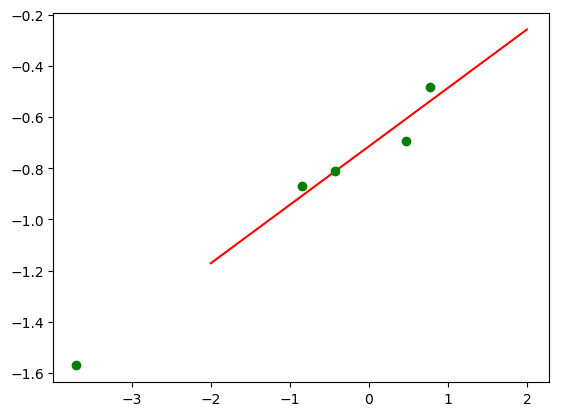

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13d0a8208>

In [60]:
xx = [-2., 2.]
yy = aest .* xx .+ best
p_.plot(xx,yy,"r-")
p_.plot(x,y,"go")